In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import maxabs_scale
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
path = '100k/'
userdf = pd.read_csv(path+'u.user',delimiter='|',header=None,engine='python')
ratedf = pd.read_csv(path+'u.data',delimiter='\t',header=None,engine='python')
moviedf = pd.read_csv(path+'u.item',index_col=0,delimiter='|',header=None,engine='python')

In [132]:
traindf = pd.read_csv(path+'ua.base',delimiter='\t',header=None,engine='python')
testdf = pd.read_csv(path+'ua.test',delimiter='\t',header=None,engine='python')

In [133]:
print len(traindf),len(testdf)

90570 9430


In [73]:
moviedf.head()

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
0,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


737 20


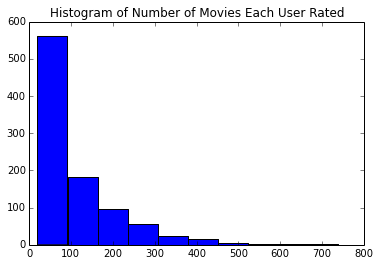

In [74]:
count = ratedf.groupby(0).size().values
print max(count),min(count)
plt.hist(count)
plt.title('Histogram of Number of Movies Each User Rated')
plt.show()

In [88]:
pred1 = np.zeros(len(testdf))

In [89]:
# global average
global_av = np.mean(traindf[2])
# user rating average
user_av = traindf[2].groupby(traindf[0]).mean().mean()
traindf[2].groupby(traindf[0]).mean().sum()/943.0
# # group rating by user  ID
user_gb = traindf.groupby(0)
# # movie rating average
movie_av =  traindf[2].groupby(traindf[1]).mean().mean()

# group rating by movie
movie_gb = traindf.groupby(1)
# true rating
test_y = testdf[2]
movies = set(traindf[1])
for i,row in testdf.iterrows():
    userid = row[0]
    movieid = row[1]
    user_bias = np.mean(traindf.loc[user_gb.groups[userid]][2])-user_av
    if movieid in movies:
        movie_bias = np.mean(traindf.loc[movie_gb.groups[movieid]][2])-movie_av
    else:
        movie_bias = 0
    pred1[i] = global_av + user_bias +movie_bias


In [90]:
pred = np.zeros(len(testdf))
print np.sqrt(mean_squared_error(test_y,np.full(len(testdf),global_av)))
print np.sqrt(mean_squared_error(test_y,np.full(len(testdf),user_av)))
print np.sqrt(mean_squared_error(test_y,np.full(len(testdf),movie_av)))
print np.sqrt(mean_squared_error(test_y,pred1))

1.1220056791
1.12018014717
1.23541803666
1.0723114217


In [ ]:
1.15367594779
1.15486714246
1.23301834208
1.04894305204


1.13066381947
1.13141815885
1.2129116614
1.15525527396



In [ ]:
# userdf[0]-=1
# userdf[4] = userdf[4].str[:2]
# print userdf.head()
# zip_code = np.linspace(0,99,100).astype(int)
# zip_code = [str(x).zfill(2) for x in zip_code]
# av = userdf.groupby(4)
# scores = dict()
# for area in zip_code:
#     users = userdf.loc[av.groups[area]][0]
#     s = 0
#     n = 0
#     for user in users:
#         s+=sum(ratedf.loc[rate_gb.groups[user]][2])
#         n+=len(rate_gb.groups[user])
#     scores[area] = s*1.0/n
# print scores

In [ ]:
# import operator
# sorted_score = sorted(scores.items(), key=operator.itemgetter(1))
# x_ticks = [x[0] for x in sorted_score]
# for item in sorted_score:
#     print item[0],item[1]
# y = [x[1] for x in sorted_score]
# print min(y),max(y)
# fig, ax = plt.subplots(figsize=(20,10))
# ind = np.arange(100)
# # plt.fig(figsize=(200,50))
# ax.bar(ind+0.5,y,width=0.5)
# plt.setp(ax.get_xticklabels(),visible=False)
# plt.xlabel(x_ticks)

# plt.show()
# plt.bar(range(100),scores,align='edge',width = 1)
# plt.xlim(xmin=0,xmax=150)
# plt.show()


In [9]:
pred3 = np.zeros(len(testdf))

In [126]:
m = pd.DataFrame(index=np.arange(1682)+1,columns=np.arange(943)+1)
# m = pd.DataFrame(columns=np.arange(1682)+1,index=np.arange(943)+1)
for item in traindf.iterrows():
    item = item[1]
    m[item[0]].loc[item[1]]=item[2]
print m.head()
# for i in range(1,6041):
#     m.loc[i] = m.loc[i].fillna(np.mean(m.loc[i]*1.0))
    

  1    2    3    4    5    6    7    8    9    10  ...   934  935  936  937  \
1   5    4  NaN  NaN  NaN    4  NaN  NaN  NaN    4 ...     2    3    4  NaN   
2   3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...     4  NaN  NaN  NaN   
3   4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN    4  NaN   
4   3  NaN  NaN  NaN  NaN  NaN    5  NaN  NaN    4 ...     5  NaN  NaN  NaN   
5   3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN  NaN   

   938  939  940  941  942  943  
1    4  NaN  NaN    5  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN    5  
3  NaN  NaN  NaN  NaN  NaN  NaN  
4  NaN  NaN    2  NaN  NaN  NaN  
5  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 943 columns]


In [114]:
m.head()

,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
1,5,4,NaN,NaN,NaN,4,NaN,NaN,NaN,4,...,2,3,4,NaN,4,NaN,NaN,5,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,4,...,5,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
m = m.as_matrix()
user_avs = list(traindf[2].groupby(traindf[0]).mean())

In [119]:
from scipy.stats import pearsonr
def knn_imp(train_x,train_y,test_x,k):
    train_x = np.array(train_x,dtype=float)
    train_y = np.array(train_y,dtype=float)
    test_x = np.array(test_x,dtype=float)
    sim = np.zeros(len(train_y))
    for i,row in enumerate(train_x):
        sim[i]=pearson(test_x,row)
#     print sim
    index = sim.argsort()[-1*k:]
    s = sim[index]
    r = train_y[index]
    return np.dot(s,r)/np.sum(np.absolute(s))
#     return (train_y[sim.argsort()[-1*k:]]*1.0).mean()
def pearson(x,y):
    index = np.where(~np.isnan(x*y))[0]
    print index
    if len(index)==0: return 0.5
    rx = x[index]-np.nanmean(x)
    ry = y[index]-np.nanmean(y)
    result = np.dot(rx,ry)/(np.sum(rx**2)*np.sum(ry**2))**0.5
    if np.isnan(result): return 0
    else: return result

In [129]:
# sim = np.array((1682,1682))
for i in range(1,3):
    for j in range(i+1,3):
        sim[i][j] = pearson(m[i],m[j])

[5 4 nan nan nan 4 nan nan nan 4 nan nan 3 nan 1 5 nan 5 nan 3 5 nan 5 nan
 5 3 nan nan nan nan nan nan nan nan nan nan nan 5 nan nan 4 5 5 4 5 nan
 nan nan 2 nan nan nan nan 4 nan 4 5 5 2 nan nan 2 3 4 3 nan nan nan nan 4
 nan 4 2 nan 4 nan 5 nan 4 nan 4 4 4 2 nan nan nan nan 5 nan nan 4 5 4 nan
 5 4 nan 4 nan 3 3 nan nan nan 4 nan 4 nan nan nan nan nan nan nan nan 4
 nan nan 4 4 nan nan 3 4 nan nan 4 nan 5 nan nan nan 5 nan nan 3 4 nan nan
 3 nan nan 4 3 nan nan nan nan nan 5 nan nan nan nan nan 5 4 nan 4 nan 4
 nan nan nan nan nan 5 nan nan nan nan nan 3 nan nan 3 4 nan nan 3 4 nan 4
 nan nan nan nan 5 nan nan nan 4 4 nan nan nan 4 1 5 3 3 3 2 nan nan nan
 nan 5 5 nan nan 2 nan nan 4 nan nan nan nan nan 4 4 nan nan nan nan nan
 nan 5 3 nan nan 3 4 nan nan nan nan nan nan nan 4 4 nan 4 nan 3 4 4 4 5 5
 3 nan 5 nan nan nan nan nan 3 5 nan 5 nan nan 3 nan nan 3 nan nan 4 4 5 4
 nan 3 nan nan nan nan nan nan 4 nan nan nan 5 5 4 2 5 4 5 3 5 3 nan 4 nan
 5 nan 5 nan 5 nan nan nan 4 5 4 5 

In [120]:
pred3 = np.zeros(len(testdf))
for k in [200]:
    for i,item in enumerate(testdf.iterrows()):
        item = item[1]
        user = item[0]
        movie = item[1]
        index = pd.notnull(m[user])
        train_y = m[user][index]
        train_x = m.loc[index]
        test_x = m.loc[movie]
        pred3[i] = knn_imp(train_x,train_y,test_x,k)
        break
    print mean_squared_error(test_y,pred3)**0.5
        

[ 14  57  61 143 157 180 183 200 233 243 285 291 296 298 342 380 386 405
 416 456 457 462 482 485 502 532 536 654 732 744 828 853 882 885 893 895
 900 918 935]
[200 233 291 386 565 654 885 895]
[ 61 243 285 342 405 462 485 536 698 853 885 935]
[ 61 143 157 200 233 285 296 298 333 342 372 386 405 416 456 532 536 654
 757 853 882 895 918]
[233 405 416 654 885 918]
[ 89 180 485 536 654 757 827 935]
[ 14  57  61 143 157 180 183 200 213 233 243 285 291 296 298 320 333 342
 353 386 405 416 456 457 462 472 485 536 565 654 698 732 757 853 885 893
 895 918 935]
[ 57  61  89 143 157 200 213 233 296 320 333 342 353 386 405 456 457 502
 532 654 744 757 853 877 882 895]
[ 14  61  89 143 180 183 200 233 243 320 333 342 348 353 405 456 457 472
 482 485 532 539 654 698 732 744 836 853 877 882 885 893 895 918 935]
[ 89 157 180 200 233 291 298 333 342 348 353 386 405 462 485 502 532 536
 584 698 744 827 828 860 882 885 893]
[ 57  89 115 157 183 200 213 223 233 285 296 333 342 386 405 416 456 536
 565 65

global: 1.12566165554   
user-average:1.12374268744   
movie-average:1.24035091914   
combined:1.08504694818   
item-based unweighted knn:     
1.49576992804   
1.20687418755   
1.13508774029   
1.08331361975    
1.06523704192   
1.05778079493    
1.05266468426    
1.04912541625


weighted item based
k = 1,3,5,10,15,20,25,50
1.49079892749   
1.21362493424   
1.14229869195    
1.12560730658    
1.19329053212   
1.2416252918   
1.27061276955   
1.36583396992

user-based unweighted knn:     
k=1 1.6700142669  
k=3 1.40377137599  
k=5 1.3423389031  
k=10 1.28925503918  
k=15 1.27249989558  
k=20 1.26164631112  
k=25 1.25401005602  
k=50 1.23756805347  

In [ ]:
print mean_squared_error(test_y[:10000],pred3[:10000])**0.5

In [ ]:
print mean_squared_error(test_y[:100000],pred3[:100000])**0.5

In [ ]:
k = [1,3,5,10,20,30,50]
e = [1.50366219611,1.17686022959,1.10125383087,1.04261210428,1.0774008075,1.11990571032,1.4798251248]
plt.plot(k,e)
plt.xlabel('K')
plt.ylabel('RMSE')

In [ ]:
1 1.50366219611
3 1.17686022959
5 1.10125383087
10 1.04261210428
1.0774008075
1.11990571032
50 1.4798251248
100 1.96345392103
150 2.35112978989

In [ ]:
# userdf[0]-=1
# print min(userdf[2]),max(userdf[2])
# userdf[2] = (userdf[2]-min(userdf[2]))/(max(userdf[2])-min(userdf[2]))
age=[1,18,25,35,45,50,56]
categories=[1,2,3,4,5,6,7]
age_dict = dict(zip(age,categories))
userdf[2] = map(lambda x:age_dict[x],userdf[2])
userdf[2] = maxabs_scale(userdf[2])
# userdf = pd.concat([userdf,pd.get_dummies(userdf[2],prefix='age')],axis=1)
# userdf = userdf.drop(2,axis=1)
userdf[4] = userdf[4].str[:1]
# userdf = pd.concat([userdf,pd.get_dummies(userdf[2],prefix='age')],axis=1)
userdf = userdf.drop(2,axis=1)
userdf = pd.concat([userdf,pd.get_dummies(userdf[1],prefix='gender')],axis=1)
userdf = userdf.drop(1,axis=1)
userdf = pd.concat([userdf,pd.get_dummies(userdf[3],prefix='occ_')],axis=1)
userdf = userdf.drop(3,axis=1)
userdf = pd.concat([userdf,pd.get_dummies(userdf[4],prefix='zip_code')],axis=1)
userdf = userdf.drop(4,axis=1)
print userdf.head()
print userdf.shape

In [ ]:
# from scipy.stats import pearsonr
# print userdf.loc[100][1:]
# print userdf.loc[101][1:]
# print pearsonr(userdf.loc[100][1:],userdf.loc[101][1:])# print pearsonr(userdf.loc[100][1:],userdf.loc[0][1:])

In [ ]:
pred2 = np.zeros(len(testdf))
movieid = testdf[1]
# for item in testdf.loc[:10]:
#     print item
# s = 0
count = 0
# item = testdf.loc[0]
# print item
# movieid = 
for k in [150]:
    for i,id in enumerate(movieid[:10000]):
        index = np.where(traindf[1]==id)[0]
        if len(index)<k: 
            pred2[i] = pred1[i]
            count+=1
            continue
        users = traindf.loc[movie_gb.groups[id]][0]-1
        train_y = traindf.loc[movie_gb.groups[id]][2]
        train_x = userdf.loc[users]
        train_x = train_x.as_matrix()[:,1:]
        test_x = userdf.loc[id]
        test_x = test_x.as_matrix()[1:]
        test_x = test_x.reshape(1,-1)
        knn = KNeighborsRegressor(n_neighbors=k,metric='euclidean')
        knn.fit(train_x,train_y)
        pred2[i] = knn.predict(test_x)
    print k,np.sqrt(mean_squared_error(test_y[:10000],pred2[:10000]))
    print count

In [ ]:
print k,np.sqrt(mean_squared_error(test_y[:10000],pred2[:10000]))

In [ ]:
moviedf.head()
genres = ['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama',\
    'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
for genre in genres:
    moviedf[genre] = np.zeros(len(moviedf))
for i,title in enumerate(moviedf[2]):
    genres = title.split('|')
    for genre in genres:
        moviedf[genre][i+1]=1
print moviedf.head()

In [ ]:
# moviedf = moviedf.drop(0,axis=0)
moviedf = moviedf.drop([1,2],axis=1)

In [ ]:
moviedf

In [ ]:
rate_matrix = ratedf.as_matrix()

train_value,test_value = train_test_split(rate_matrix,test_size=0.2,random_state=0)

In [ ]:
moviedf[0]

In [ ]:
train_x


In [ ]:
pred2 = np.zeros(100)
pred2.fill(np.mean(train_value[:,-1]))

In [ ]:
userid = test_value[:100,0]
test_y =test_value[:100,-1]
no_profile = set(np.linspace(1,3952,3952).astype(int))-set(moviedf.index)

# id = movieid[0]
# print id
# print id
# s = 0
count = 0
for k in [10,15,25,50,100,150]:
    for i,id in enumerate(userid[:100]):
        index = np.where(train_value[:,0]==id)[0]
        if len(index)<k: 
            count+=1
            continue
        for n,j in enumerate(index):
            if train_value[:,1][j] in no_profile: 
                
                index=np.delete(index,n)
        
        train_movieid =train_value[:,1][index]
        print train_movieid
        train_y = train_value[:,-1][index]
        train_x = moviedf.loc[train_movieid]
        train_x = train_x.as_matrix()[:,1:]
        test_x = moviedf.loc[id]
        test_x = test_x.as_matrix()[1:]
        test_x = test_x.reshape(1,-1)
        knn = KNeighborsRegressor(n_neighbors=k,metric='euclidean')
        pred2[i] = knn.fit(train_x,train_y).predict(test_x)
    print k,np.sqrt(mean_squared_error(test_y,pred2))

In [ ]:
yjy = np.ones(6040)
yjy[0] = 0
knn.predict(yjy.reshape(1,-1))